In [1]:
#Imports
import tensorflow as tf
import keras as k
import numpy as np
import matplotlib.pyplot as plt
import cv2
import np_utils
import csv
import os
import math
from random import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from keras import backend as K

In [2]:
#Create pairs based on csv file
csvfile = open('data/train.csv', 'r')
csvreader = csv.reader(csvfile, delimiter=',', quotechar='|')

pairs = []
prev_ids = []
for i, row in enumerate(csvreader):
    if i != 0:
        curr_id = row[-1]
        curr_name = row[1]

        if curr_id in prev_ids:
            index_of_pair = prev_ids.index(curr_id)
            pairs[index_of_pair].append(curr_name)
        else:
            prev_ids.append(curr_id)
            pairs.append([curr_name])

In [53]:
#Convert filenames to np.arrays in the pairs
for i in range(len(pairs)):
    for j in range(len(pairs[i])):
        y = plt.imread(os.path.join("data/train_images", pairs[i][j]))/255
        # y = np.asarray(y)/255
        data = [y]
        data = np.asarray(data)
        pairs[i][j] = tf.image.resize(data, (80,80)).numpy()[0]

KeyboardInterrupt: 

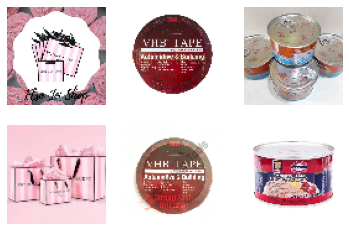

In [58]:
#check that pairs are chosen correctly
nrows = 2
ncols = 3
fig, axes = plt.subplots(nrows, ncols)
i = 0
while i < nrows*ncols/2:
    axes.flat[i].imshow(pairs[i][0])
    axes.flat[i+ncols].imshow(pairs[i][1])
    axes.flat[i].set_axis_off()
    axes.flat[i+ncols].set_axis_off()
    i += 1
    

In [190]:
#Function to randomly generate a negative for the A, P, N Triplet
def generate_random(not_this_pair):
    rndm_class = math.floor(random()*len(pairs)) #choose random number up to len(pairs)
    rndm_item = math.floor(random()*len(pairs[rndm_class]))
    for arr in not_this_pair:
        if np.array_equal(arr, rndm_item):
            return generate_random(not_this_pair)
        else:
            return rndm_class, rndm_item

In [191]:
#sort training data into triplets (anchor, positive, negative)
x_train = []
for pair in pairs:
    for i in range(1, len(pair)):
        temp = []
        temp.append(pair[0])#anchor
        temp.append(pair[i])#positive
        #randomly choose image from database
        rndm_class, rndm_item = generate_random(pair)
        temp.append(pairs[rndm_class][rndm_item])
        x_train.append(temp)

In [3]:
#load or save the training data for future use

# np.save("x_train_array", x_train)
x_train = np.load("x_train_array.npy")

In [4]:
#split training data into the three inputs for model (anchor, positive, negative)
a_train = []
p_train = []
n_train = []
for i in range(len(x_train)):
    a_train.append(x_train[i][0])
    p_train.append(x_train[i][1])
    n_train.append(x_train[i][2])

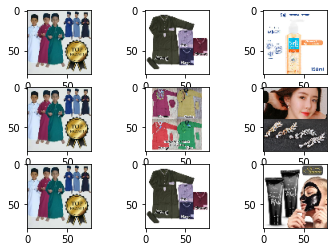

In [6]:
#check that triplets are chosen correctly
nrows = 3
ncols = 3
fig, axes = plt.subplots(nrows, ncols)
img_number = 8
for i in range(ncols):
    axes.flat[i].imshow(x_train[img_number][i])
    axes.flat[i+ncols].imshow(x_train[img_number+1][i])
    axes.flat[i+2*ncols].imshow(x_train[img_number+2][i])

In [30]:
#define our triplet loss function
def triplet_loss(y_true, y_pred):
    anchor_out = y_pred[:, 0:100]
    positive_out = y_pred[:, 100:200]
    negative_out = y_pred[:, 200:300]

    pos_dist = K.sum(K.abs(anchor_out-positive_out), axis=1)
    neg_dist = K.sum(K.abs(anchor_out-negative_out), axis=1)

    probs = K.softmax([pos_dist, neg_dist], axis=0)
    return K.mean(K.abs(probs[0]) + K.abs(1.0-probs[1]))

In [8]:
#Create base 1 input model
input_layer = Input((80, 80, 3))
x = Conv2D(32, 3, activation="relu")(input_layer)
x = Conv2D(32, 3, activation="relu")(x)
x = MaxPooling2D(2)(x)
x = Conv2D(64, 3, activation="relu")(x)
x = Conv2D(64, 3, activation="relu")(x)
x = MaxPooling2D(2)(x)
x = Conv2D(128, 3, activation="relu")(x)
x = Flatten()(x)
x = Dense(100)(x)
model = Model(input_layer, x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 78, 78, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 76, 76, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 64)        0     

In [9]:
#Create the concatenated model with 3 inputs

triplet_model_a = Input((80, 80, 3))
triplet_model_p = Input((80, 80, 3))
triplet_model_n = Input((80, 80, 3))
triplet_model_out = Concatenate()([model(triplet_model_a), model(triplet_model_p), model(triplet_model_n)])
triplet_model = Model([triplet_model_a, triplet_model_p, triplet_model_n], triplet_model_out)
triplet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 100)          3019524     input_2[0][0]                    
                                                                 input_3[0][0]              

In [10]:
#Compile model with triplet_loss and adam optimiser

triplet_model.compile(loss=triplet_loss, optimizer = "adam")

In [12]:
#Create data_generator which feeds in the triplets to model
def data_generator(batch_size=64):
    while True:
        a = []
        p = []
        n = []
        for i in range(batch_size):
            a.append(a_train[i])
            p.append(p_train[i])
            n.append(n_train[i])
        yield ([np.array(a), np.array(p), np.array(n)], np.zeros((batch_size, 1)).astype("float32"))

In [14]:
#Train data
triplet_model.fit(data_generator(), steps_per_epoch = 200, epochs=2)

Epoch 1/2
200/200 [==============================] - 345s 2s/step - loss: 0.1892
Epoch 2/2
200/200 [==============================] - 341s 2s/step - loss: 0.1875


In [16]:
#Function to deduce whether two products (feeds in two np arrays) are the same using model
def same_product(img_arr_one, img_arr_two):
    testing = np.asarray([img_arr_one, img_arr_two])
    predictions = triplet_model.layers[3].predict(testing)
    distf = np.linalg.norm(predictions[0]-predictions[1])
    if distf < 26.6: #arbitrary value selected to decide whether two products are similar enough
        return [True, distf] 
    else:
        return [False, distf]

In [63]:
#Check accuracy (only on training_data because kaggle does not provide testing_data)
errors = 0
for triplet in x_train:
    if same_product(triplet[0], triplet[1])[0] == False:
        errors += 1
    if same_product(triplet[0], triplet[2])[0] == True:
        errors += 1
    if same_product(triplet[2], triplet[1])[0] == True:
        errors += 1
print((1-errors/(3*len(x_train)))*100)
#73.323453245436756% with 200 steps per epoch and size=(80, 80)

61.111111111111114
